In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score as r2
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

### Загружаем данные

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df.shape[1] - 1 == test_df.shape[1]

True

### Анализ и подготовка данных

In [4]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,4567,44,1.0,36.847630,19.094182,5.0,5,9.0,1970,0.036122,B,B,24,4378,0,1036.0,1,1,B
1,5925,62,1.0,42.493907,42.568133,10.0,7,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A
2,960,27,2.0,59.463678,NaN,9.0,19,19.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B
3,3848,23,3.0,49.646030,33.893825,6.0,2,2.0,1965,0.014073,B,B,2,475,0,NaN,0,0,B
4,746,74,1.0,53.837056,NaN,1.0,8,17.0,1977,0.309479,B,B,35,7715,4,990.0,0,6,B


In [5]:
train_df.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630
4,13866,94,2.0,64.285067,38.562517,9.0,16,16.0,1972,0.282798,B,B,33,8667,2,NaN,0,6,B,343995.102962
5,5804,99,3.0,62.528465,47.103833,6.0,9,9.0,1972,0.012339,B,B,35,5776,1,2078.0,2,4,B,161044.944138
6,8864,44,1.0,33.938750,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.739272
7,13072,59,2.0,50.391814,32.893256,8.0,8,17.0,1986,0.019509,B,B,37,7687,11,176.0,5,5,B,326174.175191
8,9951,1,1.0,46.887892,44.628132,1.0,12,20.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,160400.401732
9,8094,6,3.0,79.867477,75.085125,1.0,3,17.0,2014,0.243205,B,B,5,1564,0,540.0,0,0,B,194756.023945


In [6]:
train_df.dtypes

Id                 int64
DistrictId         int64
Rooms            float64
Square           float64
LifeSquare       float64
KitchenSquare    float64
Floor              int64
HouseFloor       float64
HouseYear          int64
Ecology_1        float64
Ecology_2         object
Ecology_3         object
Social_1           int64
Social_2           int64
Social_3           int64
Healthcare_1     float64
Helthcare_2        int64
Shops_1            int64
Shops_2           object
Price            float64
dtype: object

##### Потребуются изменения:
##### Есть пропущенные значения в столбцах: LifeSquare, Healthcare_1. Заполним их с помощью машинного обучения
##### KitchenSquare - есть значения 1, что очевидно не соответствует действительности. Рассчитаем значение ячеек, в которых площадь равна 1 по формуле (площадь квартиры * средняя от (площадь кухни / площадь квартиры)).  Добавим столбец Sq_koef = площадь квартиры / площадь кухни
##### Ecology_2, Ecology_3 и Shops_2 заменим на бинерные значения 0 и 1

In [7]:
train_df['Sq_koef'] = train_df['KitchenSquare'] / train_df['Square']
test_df['Sq_koef'] = test_df['KitchenSquare'] / test_df['Square']

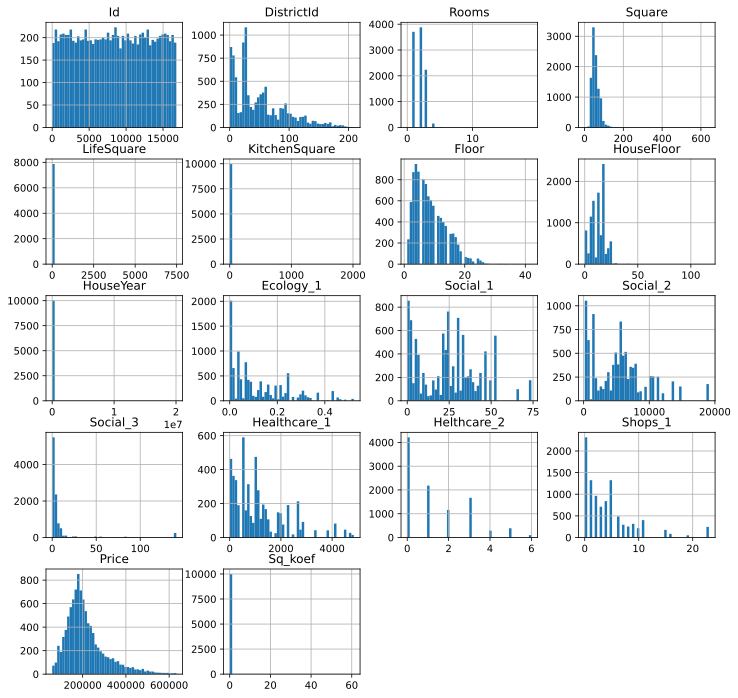

In [8]:
train_df.hist(figsize=(12,12), bins=50)
plt.show()

In [9]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price,Sq_koef
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399,0.123297
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865,0.749376
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028,0.000000
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942,0.022591
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879,0.120688
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171,0.165121
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570,61.034810


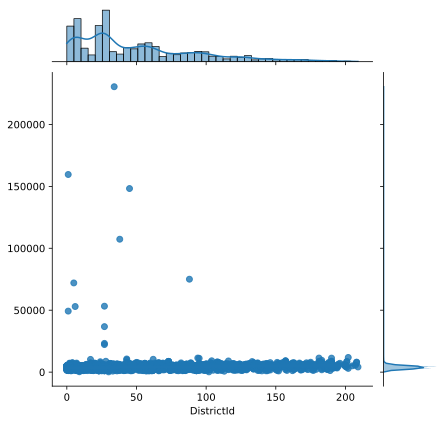

In [10]:
##Посмотрим, есть ли взаимосвязь между ценой за квадратный метр и районом

sns.jointplot(train_df['DistrictId'], train_df['Price'] / train_df['Square'], kind='reg')

plt.show()

#### В некоторых районах можно наблюдать присутствие самого дорого жилья (возможно выбросы), но четкой взаимосвязи между ценой квартир и районом нет. 


In [11]:
train_df['0_id'] = [x for x in range(len(train_df))]
test_df['0_id'] = [x for x in range(len(test_df))]

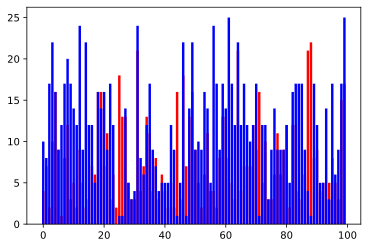

In [12]:
plt.bar(train_df['0_id'][:100], train_df['Floor'][:100], color='red')
plt.bar(train_df['0_id'][:100], train_df['HouseFloor'][:100], color='blue')

plt.show()

In [13]:
### Из графика мы видим, что есть значения этажей, которые превышают этажность дома. 
### Посмотрим, сколько таких значений и заменим их.


train_df.loc[train_df['Floor'] > train_df['HouseFloor']]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Sq_koef,0_id
17,1190,8,2.0,49.396000,28.299600,5.0,6,5.0,1962,0.458174,...,26,4439,1,1130.0,1,5,B,186971.926566,0.101223,17
19,367,45,1.0,42.367289,40.012529,1.0,16,14.0,2015,0.195781,...,23,5212,6,NaN,3,2,B,250466.980777,0.023603,19
21,8471,20,3.0,75.611065,47.494621,8.0,11,9.0,1976,0.019509,...,37,7687,11,176.0,5,5,B,366916.246494,0.105805,21
24,4717,27,1.0,44.203947,NaN,0.0,2,0.0,1977,0.072158,...,2,629,1,NaN,0,0,A,135466.559958,0.000000,24
25,4521,6,2.0,65.409965,NaN,1.0,18,1.0,1977,0.243205,...,5,1564,0,540.0,0,0,B,191205.272608,0.015288,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9960,16258,48,3.0,96.056784,98.152802,1.0,15,1.0,2017,0.041125,...,46,9515,5,NaN,1,10,B,524365.550705,0.010411,9960
9968,9920,1,3.0,86.487550,NaN,1.0,18,17.0,1977,0.007122,...,1,264,0,NaN,0,1,B,248248.935528,0.011562,9968
9970,13501,6,1.0,41.310416,19.117077,9.0,18,17.0,1977,0.243205,...,5,1564,0,540.0,0,0,B,114878.830713,0.217863,9970
9975,4944,6,2.0,52.573133,NaN,1.0,18,17.0,1977,0.243205,...,5,1564,0,540.0,0,0,B,154366.031184,0.019021,9975


##### Мы видим, что 1825 значений этажей заполнено неверно.
##### + изменим следующее:
##### В строках, где количество этажей (HouseFloor) 0 или 1 заменим эти значения на этаж (Floor).
##### В строках, где этаж (Floor) превышает количество этажей в доме, заменим количество этажей (HouseFloor) на этаж.

##### + добавим новую фичу - новостройка (0 - если дом старше 5 лет, 1 - если дому 5 и менее лет)

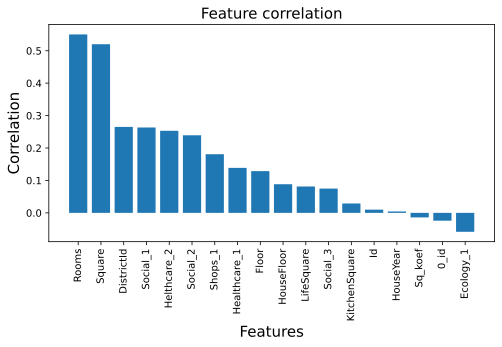

In [14]:
## Посмотрим корреляцию признаков с ценой

correlation = train_df.corrwith(train_df['Price']).sort_values(ascending=False)
correlation.drop('Price', inplace=True)

plt.figure(figsize = (8, 4))
plt.bar(correlation.index, correlation)
plt.xticks(rotation='90')
plt.xlabel('Features', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.title('Feature correlation', fontsize=15)
plt.show()

### Подготовка данных

In [15]:
class DataPreprocessor:
    def __init__(self):
        self.max_floor = None
        self.means_kf = None # средняя от (площадь кухни / площадь квартиры)
        
        self.KitchenSquare_min = 6
        self.HouseFloor_min = 2
        self.HouseYear_max = 2022
        self.LifeSquare_min = 10
        
        
    def fit(self, train_df):
        self.max_floor = train_df['Floor'].max()
        self.means_kf = train_df['Sq_koef'].mean()
        self.mean_lifesquare = train_df['LifeSquare'].mean()
        
    def transform(self, train_df):
        
        # Ecology_2, Ecology_3 и Shops_2 заменим на бинарные значения 0 и 1
        
        train_df.replace({'Ecology_2': {'A': 0, 'B': 1}}, inplace=True)
        train_df.replace({'Ecology_3': {'A': 0, 'B': 1}}, inplace=True)
        train_df.replace({'Shops_2': {'A': 0, 'B': 1}}, inplace=True)
        
        # KitchenSquare - есть значения 1, что очевидно не соответствует действительности. 
        # Рассчитаем значение ячеек, в которых площадь менее 6 по формуле 
        # (площадь квартиры * среднее от (площадь кухни / площадь квартиры) 
        
        condition_kitchen_square = (train_df['KitchenSquare'] < self.KitchenSquare_min)
        train_df.loc[condition_kitchen_square, 'KitchenSquare'] = train_df.loc[condition_kitchen_square, 'Square'] * self.means_kf

        
        # HouseFloor, Floor
        
        # В строках, где этаж (Floor) превышает количество этажей в доме, заменим количество этажей (HouseFloor) на этаж.
        
        floor_condition = (train_df['HouseFloor'] < train_df['Floor'])
        train_df.loc[floor_condition, 'HouseFloor'] = train_df.loc[floor_condition, 'Floor']
        
        # В строках, где количество этажей (HouseFloor) 0 или 1 заменим эти значения на этаж (Floor).
        
        house_floor_condition = (train_df['HouseFloor'] < self.HouseFloor_min)
        train_df.loc[house_floor_condition, 'HouseFloor'] = train_df.loc[house_floor_condition, 'Floor']
        
        
        # LifeSquare - заменим все пустые значения по формуле (Площадь - 10% площади - площадь кухни)
        
        LifeSquare_condition = 0.9 * train_df['Square'] - train_df['KitchenSquare']
        train_df['LifeSquare'].fillna(value=LifeSquare_condition, inplace=True)
        
        # LifeSquare - значения менее 10 заменим на среднее
        LifeSquare_condition_1 = (train_df['LifeSquare'] < self.LifeSquare_min)
        train_df.loc[LifeSquare_condition_1, 'LifeSquare'] = self.mean_lifesquare
        
        # HouseYear - если год постройки больше 2022 - заменим на 2022
        HouseYear_condition = (train_df['HouseYear'] > self.HouseYear_max)
        train_df.loc[HouseYear_condition, 'HouseYear'] = self.HouseYear_max
        
        
        # Предсказание пропущенных значений Healthcare_1
        
        train_df['Id'] = train_df['Id'].astype(str)
        train_df['DistrictId'] = train_df['DistrictId'].astype(str)
        test_df['Id'] = test_df['Id'].astype(str)
        test_df['DistrictId'] = test_df['DistrictId'].astype(str)
        
        target_name = 'Healthcare_1'
        
        train_df['nan'] = 0
        train_df.loc[train_df[target_name].isna(), 'nan'] = 1
        
        df_test = train_df[train_df['nan'] == 1] 
        df_train = train_df[train_df['nan'] == 0] 
        
        df_train = df_train.drop(columns='nan')
        
        x = df_train.drop(columns=[target_name, '0_id'])
        y = df_train[target_name]
        
        x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size=0.3, shuffle=True, random_state=42)

        rf_model = RandomForestRegressor(n_estimators=1000, max_depth=10, random_state=42)
        rf_model.fit(x_train, y_train)

        y_train_pred = rf_model.predict(x_train)
        y_test_pred = rf_model.predict(x_valid)
        
        v = [x for x in df_test['0_id']]
        df_test = df_test.drop(columns=[target_name, '0_id'])
        df_test = df_test.drop(columns='nan')
        
        df_test[target_name] = rf_model.predict(df_test)
        df_test[target_name] = df_test[target_name].apply(int)
        df_test['0_id'] = v
        
        train_df = pd.concat([df_train, df_test])
        train_df = train_df.sort_values(by=['0_id'])
        
        
        return train_df

In [16]:
## Обновим данные

preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df_1 = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

In [17]:
train_df_1.head(10)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Sq_koef,0_id
0,11809,27,3.0,115.027311,93.524580,10.000000,4,10.0,2014,0.075424,...,11,3097,0,666.0,0,0,1,305018.871089,0.086936,0
1,3013,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,...,30,6207,1,1183.0,1,0,1,177734.553407,0.200841,1
2,8215,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,...,33,5261,0,240.0,3,1,1,282078.720850,0.127645,2
3,2352,1,1.0,40.409907,31.386503,4.982413,10,22.0,1977,0.007122,...,1,264,0,447.0,0,1,1,168106.007630,0.024746,3
4,13866,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,...,33,8667,2,1575.0,0,6,1,343995.102962,0.140001,4
5,5804,99,3.0,62.528465,47.103833,6.000000,9,9.0,1972,0.012339,...,35,5776,1,2078.0,2,4,1,161044.944138,0.095956,5
6,8864,44,1.0,33.938750,21.772930,9.000000,1,12.0,1968,0.232205,...,24,4860,1,80.0,0,3,1,142402.739272,0.265184,6
7,13072,59,2.0,50.391814,32.893256,8.000000,8,17.0,1986,0.019509,...,37,7687,11,176.0,5,5,1,326174.175191,0.158756,7
8,9951,1,1.0,46.887892,44.628132,5.781128,12,20.0,1977,0.007122,...,1,264,0,447.0,0,1,1,160400.401732,0.021327,8
9,8094,6,3.0,79.867477,75.085125,9.847406,3,17.0,2014,0.243205,...,5,1564,0,540.0,0,0,1,194756.023945,0.012521,9


### Добавление и удаление фичей

In [18]:
class FeatureGenerator:
    def __init__(self):
        self.districts_median_year = None # медианное значение года постройки дома по районам
        
    def fit(self, train_df_1):
        self.districts_median_year = train_df_1.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict()
        
    def new_features(self, train_df_1):
        # домов какого года постройки больше всего в райне
        train_df_1['DistrictYear'] = train_df_1['DistrictId'].map(train_df_1.groupby(['DistrictId'])['HouseYear'].agg('median').to_dict())
        
        # является ли дом новостройкой (1 - да, 0 - нет). Новостройкой будем считать дома, которым меньше 5 лет
        train_df_1['New_building'] = 0
        current_year = datetime.now().year
        new_building = train_df_1['HouseYear'] > (current_year - 5)
        train_df_1.loc[new_building, 'New_building'] = 1
        
        
        train_df_1.drop(['Id', 'Sq_koef', '0_id'], axis=1, inplace=True)
        
    
        return train_df_1
        

In [19]:
features_gen = FeatureGenerator()
features_gen.fit(train_df_1)
train_df_2 = features_gen.new_features(train_df_1)
test_df = features_gen.new_features(test_df)

In [20]:
train_df_2.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictYear,New_building
0,27,3.0,115.027311,93.524580,10.000000,4,10.0,2014,0.075424,1,...,11,3097,0,666.0,0,0,1,305018.871089,1977.0,0
1,22,1.0,39.832524,23.169223,8.000000,7,8.0,1966,0.118537,1,...,30,6207,1,1183.0,1,0,1,177734.553407,1977.0,0
2,1,3.0,78.342215,47.671972,10.000000,2,17.0,1988,0.025609,1,...,33,5261,0,240.0,3,1,1,282078.720850,1977.0,0
3,1,1.0,40.409907,31.386503,4.982413,10,22.0,1977,0.007122,1,...,1,264,0,447.0,0,1,1,168106.007630,1977.0,0
4,94,2.0,64.285067,38.562517,9.000000,16,16.0,1972,0.282798,1,...,33,8667,2,1575.0,0,6,1,343995.102962,1976.0,0
5,99,3.0,62.528465,47.103833,6.000000,9,9.0,1972,0.012339,1,...,35,5776,1,2078.0,2,4,1,161044.944138,1973.0,0
6,44,1.0,33.938750,21.772930,9.000000,1,12.0,1968,0.232205,1,...,24,4860,1,80.0,0,3,1,142402.739272,1977.0,0
7,59,2.0,50.391814,32.893256,8.000000,8,17.0,1986,0.019509,1,...,37,7687,11,176.0,5,5,1,326174.175191,1986.0,0
8,1,1.0,46.887892,44.628132,5.781128,12,20.0,1977,0.007122,1,...,1,264,0,447.0,0,1,1,160400.401732,1977.0,0
9,6,3.0,79.867477,75.085125,9.847406,3,17.0,2014,0.243205,1,...,5,1564,0,540.0,0,0,1,194756.023945,1977.0,0


### Обучение модели

In [21]:
target_name = 'Price'

X = train_df_2.drop(columns=target_name)
y = train_df_2[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=100)

In [22]:
#Gradient Boosting Regressor
gb_model = GradientBoostingRegressor(criterion='mse', min_samples_leaf=50, learning_rate=0.025, max_depth=13, random_state=100, n_estimators=250)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
y_valid_preds = gb_model.predict(X_valid)

print(r2(y_train, y_train_preds))
print(r2(y_valid, y_valid_preds))

0.8497621193230389
0.7518940112437511


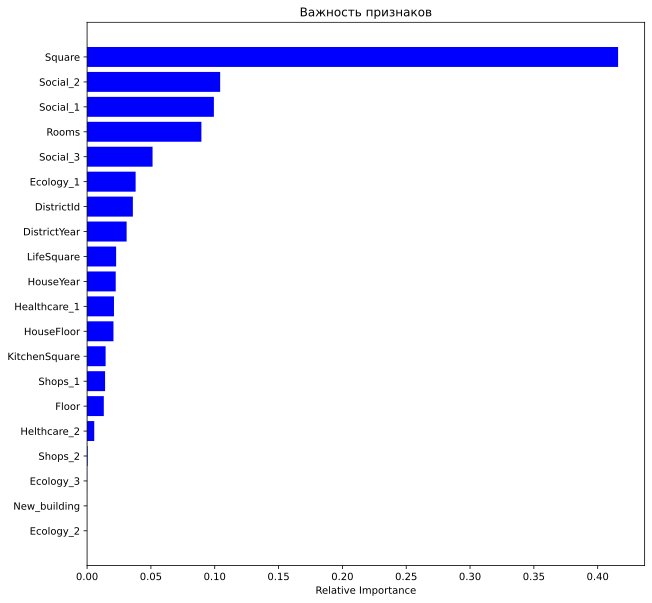

In [23]:
importances = gb_model.feature_importances_
feature_names = X.columns
indices = np.argsort(importances)
plt.figure(figsize=(10, 10), dpi=80)
plt.title('Важность признаков')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

### Предсказание на тестовых данных

In [24]:
predictions = gb_model.predict(test_df)


In [25]:
test_df.head(10)

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,DistrictYear,New_building
0,44,1.0,36.847630,19.094182,4.543196,5,9.0,1970,0.036122,1,1,24,4378,0,1036.0,1,1,1,1972.0,0
1,62,1.0,42.493907,42.568133,10.000000,7,17.0,2017,0.072158,1,1,2,629,1,529.0,0,0,0,1977.0,0
2,27,2.0,59.463678,44.517310,9.000000,19,19.0,1977,0.211401,1,1,9,1892,0,588.0,0,1,1,1977.0,0
3,23,3.0,49.646030,33.893825,6.000000,2,2.0,1965,0.014073,1,1,2,475,0,289.0,0,0,1,1977.0,0
4,74,1.0,53.837056,41.815412,6.637938,8,17.0,1977,0.309479,1,1,35,7715,4,990.0,0,6,1,1977.0,0
5,38,3.0,87.139994,53.180419,10.000000,4,23.0,2011,0.060753,1,1,15,2787,2,520.0,0,7,1,2015.5,0
6,62,1.0,46.269456,22.820239,11.000000,8,17.0,2014,0.072158,1,1,2,629,1,531.0,0,0,0,1977.0,0
7,2,2.0,48.172969,29.924204,6.000000,4,9.0,1974,0.000000,1,1,33,7425,1,614.0,2,5,1,1971.0,0
8,1,1.0,43.153761,21.017596,9.000000,10,17.0,2014,0.007122,1,1,1,264,0,618.0,0,1,1,1977.0,0
9,62,2.0,62.593787,59.786844,10.000000,1,16.0,1981,0.002212,1,1,39,7614,3,772.0,1,5,0,1977.0,0


In [26]:
submit = pd.read_csv('sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [27]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,170092.651492
1,5925,114574.800602
2,960,141866.874701
3,3848,108352.764133
4,746,194415.070273


In [29]:
submit.to_csv('project_submit.csv', index=False)